### Machine Learning Based Evaluation for Gyroscope Dataset using Feature Engineering

@ Author : Niloy Chakraborty

@ Author Contact: chakrabortyniloy2018@gmail.com

In [ ]:
# Connect to Google Colab.  If using Jupyter, then comment this part
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/THESIS/

Mounted at /gdrive
/gdrive/MyDrive/THESIS


#### Load the Libraries

In [ ]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

### Load Training and Test Dataset and Explore

In [ ]:
filepath_train = 'Gyr_25_secs_final_combined_faulty_data_train.csv'
filepath_test = 'Gyr_25_secs_final_combined_faulty_data_test.csv'

In [ ]:
header = ['AccX','AccY','AccZ','GyrX','GyrY','GyrZ','Altitude','Cmd1','Cmd2','Cmd3','Cmd4','Roll','Pitch','Yaw','ThurstRefOut1','ThurstRefOut2','ThurstRefOut3','ThurstRefOut4','Label']

### Load the train data

In [ ]:
df_train = pd.read_csv(filepath_train, header = None)
df_train = df_train.rename(columns=df_train.iloc[0]).drop(df_train.index[0])
df_train = df_train.iloc[:, 1:]
df_train["Label"] = pd.to_numeric(df_train["Label"])
df_train.head()

,AccX,AccY,AccZ,GyrX,GyrY,GyrZ,Altitude,Cmd1,Cmd2,Cmd3,Cmd4,Roll,Pitch,Yaw,ThurstRefOut1,ThurstRefOut2,ThurstRefOut3,ThurstRefOut4,Label
1,0.03380774,-0.11192460000000001,-9.492839,-0.0098925,-0.007933972,0.00108462,0.44,342.9332,-342.9577,342.8969,-342.9631,-1.965233e-06,-2.155978e-06,-5.859605e-07,-0.22403289999999998,-0.2240489,-0.22400920000000002,-0.22405239999999998,0
2,-0.116923,-0.2512355,-14.08014,-0.01084344,-0.009036063,-2.253169e-05,0.44,343.0175,-342.912,342.8928,-342.9287,-4.02452e-06,-4.6669999999999995e-06,-7.215308e-08,-0.224088,-0.224019,-0.2240065,-0.22403,0
3,0.22785189999999997,0.06732436,-13.62979,-0.008328836,-0.006301623,0.0025199379999999998,0.44,342.9608,-342.8717,343.0659,-342.8525,6.818334e-06,7.100436999999999e-06,5.960543e-07,-0.2240509,-0.2239928,-0.2241196,-0.22398020000000002,0
4,-0.01241245,-0.1545401,-13.94356,-0.01056849,-0.008493732,0.0007364108,0.44,342.8445,-343.066,342.7531,-343.0873,-3.975494e-06,-3.691068e-06,1.940148e-06,-0.223975,-0.2241197,-0.22391529999999998,-0.22413360000000002,0
5,0.21535289999999999,0.05578018,-13.64611,-0.008419157,-0.006429253,0.00240215,0.44,343.4182,-342.416,343.5187,-342.3979,1.696333e-05,1.88649e-05,1.3310810000000002e-05,-0.22434980000000002,-0.2236951,-0.2244154,-0.2236833,0


In [ ]:
drop_cols = ['Altitude','Cmd1','Cmd2','Cmd3','Cmd4','Roll','Pitch','Yaw','ThurstRefOut1','ThurstRefOut2','ThurstRefOut3','ThurstRefOut4']
df_train= df_train.drop(drop_cols,axis=1)


In [ ]:
df_train.shape

(3075000, 7)

In [ ]:
# X_train = df_train.iloc[:,:-1]
# y_train = df_train.iloc[:,-1:]

### Load the test data

In [ ]:
df_test = pd.read_csv(filepath_test, header = None)
df_test = df_test.rename(columns=df_test.iloc[0]).drop(df_test.index[0])
df_test = df_test.iloc[:, 1:]
df_test["Label"] = pd.to_numeric(df_test["Label"])
df_test.head()

,AccX,AccY,AccZ,GyrX,GyrY,GyrZ,Altitude,Cmd1,Cmd2,Cmd3,Cmd4,Roll,Pitch,Yaw,ThurstRefOut1,ThurstRefOut2,ThurstRefOut3,ThurstRefOut4,Label
1,0.03380774,-0.11192460000000001,-9.492839,-0.0098925,-0.007933972,0.00108462,0.44,342.9332,-342.9577,342.8969,-342.9631,-1.965233e-06,-2.155978e-06,-5.859605e-07,-0.22403289999999998,-0.2240489,-0.22400920000000002,-0.22405239999999998,0
2,-0.116923,-0.2512355,-14.08014,-0.01084344,-0.009036063,-2.253169e-05,0.44,343.0175,-342.912,342.8928,-342.9287,-4.02452e-06,-4.6669999999999995e-06,-7.215308e-08,-0.224088,-0.224019,-0.2240065,-0.22403,0
3,0.22785189999999997,0.06732436,-13.62979,-0.008328836,-0.006301623,0.0025199379999999998,0.44,342.9608,-342.8717,343.0659,-342.8525,6.818334e-06,7.100436999999999e-06,5.960543e-07,-0.2240509,-0.2239928,-0.2241196,-0.22398020000000002,0
4,-0.01241245,-0.1545401,-13.94356,-0.01056849,-0.008493732,0.0007364108,0.44,342.8445,-343.066,342.7531,-343.0873,-3.975494e-06,-3.691068e-06,1.940148e-06,-0.223975,-0.2241197,-0.22391529999999998,-0.22413360000000002,0
5,0.21535289999999999,0.05578018,-13.64611,-0.008419157,-0.006429253,0.00240215,0.44,343.4182,-342.416,343.5187,-342.3979,1.696333e-05,1.88649e-05,1.3310810000000002e-05,-0.22434980000000002,-0.2236951,-0.2244154,-0.2236833,0


In [ ]:
drop_cols = ['Altitude','Cmd1','Cmd2','Cmd3','Cmd4','Roll','Pitch','Yaw','ThurstRefOut1','ThurstRefOut2','ThurstRefOut3','ThurstRefOut4']
df_test= df_test.drop(drop_cols,axis=1)


### Data Pre-processing

In [ ]:
# Convert data type to Numeric
df_train = df_train.apply(pd.to_numeric)
df_test = df_test.apply(pd.to_numeric)


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3075000 entries, 1 to 3075000
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   AccX    float64
 1   AccY    float64
 2   AccZ    float64
 3   GyrX    float64
 4   GyrY    float64
 5   GyrZ    float64
 6   Label   int64  
dtypes: float64(6), int64(1)
memory usage: 187.7 MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462500 entries, 1 to 462500
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AccX    462500 non-null  float64
 1   AccY    462500 non-null  float64
 2   AccZ    462500 non-null  float64
 3   GyrX    462500 non-null  float64
 4   GyrY    462500 non-null  float64
 5   GyrZ    462500 non-null  float64
 6   Label   462500 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 28.2 MB


#### Create Sliding Windows and Apply Feature Engineering to every windows

Training Data

In [ ]:
x_list_acc = []
y_list_acc = []
z_list_acc = []
x_list_gyr = []
y_list_gyr = []
z_list_gyr = []
train_labels = []

window_size = 64
step_size = 40

# creating overlaping windows of size window-size 100
for i in range(0, df_train.shape[0] - window_size, step_size):
    accx = df_train['AccX'].values[i: i + window_size]
    accy = df_train['AccY'].values[i: i + window_size]
    accz = df_train['AccY'].values[i: i + window_size]
    gyrx = df_train['GyrX'].values[i: i + window_size]
    gyry = df_train['GyrY'].values[i: i + window_size]
    gyrz = df_train['GyrZ'].values[i: i + window_size]
    label = stats.mode(df_train['Label'][i: i + 100])[0][0]

    x_list_acc.append(accx)
    y_list_acc.append(accy)
    z_list_acc.append(accz)
    x_list_gyr.append(gyrx)
    y_list_gyr.append(gyry)
    z_list_gyr.append(gyrz)
    train_labels.append(label)

# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()

# mean
X_train['x_mean_acc'] = pd.Series(x_list_acc).apply(lambda x: x.mean())
X_train['y_mean_acc'] = pd.Series(y_list_acc).apply(lambda x: x.mean())
X_train['z_mean_acc'] = pd.Series(z_list_acc).apply(lambda x: x.mean())
X_train['x_mean_gyr'] = pd.Series(x_list_gyr).apply(lambda x: x.mean())
X_train['y_mean_gyr'] = pd.Series(y_list_gyr).apply(lambda x: x.mean())
X_train['z_mean_gyr'] = pd.Series(z_list_gyr).apply(lambda x: x.mean())

# std dev
X_train['x_std_acc'] = pd.Series(x_list_acc).apply(lambda x: x.std())
X_train['y_std_acc'] = pd.Series(y_list_acc).apply(lambda x: x.std())
X_train['z_std_acc'] = pd.Series(z_list_acc).apply(lambda x: x.std())
X_train['x_std_gyr'] = pd.Series(x_list_gyr).apply(lambda x: x.std())
X_train['y_std_gyr'] = pd.Series(y_list_gyr).apply(lambda x: x.std())
X_train['z_std_gyr'] = pd.Series(z_list_gyr).apply(lambda x: x.std())

# avg absolute diff
X_train['x_aad_acc'] = pd.Series(x_list_acc).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_acc'] = pd.Series(y_list_acc).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_acc'] = pd.Series(z_list_acc).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['x_aad_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train['x_min_acc'] = pd.Series(x_list_acc).apply(lambda x: x.min())
X_train['y_min_acc'] = pd.Series(y_list_acc).apply(lambda x: x.min())
X_train['z_min_acc'] = pd.Series(z_list_acc).apply(lambda x: x.min())
X_train['x_min_gyr'] = pd.Series(x_list_gyr).apply(lambda x: x.min())
X_train['y_min_gyr'] = pd.Series(y_list_gyr).apply(lambda x: x.min())
X_train['z_min_gyr'] = pd.Series(z_list_gyr).apply(lambda x: x.min())


# max
X_train['x_max_acc'] = pd.Series(x_list_acc).apply(lambda x: x.max())
X_train['y_max_acc'] = pd.Series(y_list_acc).apply(lambda x: x.max())
X_train['z_max_acc'] = pd.Series(z_list_acc).apply(lambda x: x.max())
X_train['x_max_gyr'] = pd.Series(x_list_gyr).apply(lambda x: x.max())
X_train['y_max_gyr'] = pd.Series(y_list_gyr).apply(lambda x: x.max())
X_train['z_max_gyr'] = pd.Series(z_list_gyr).apply(lambda x: x.max())

# max-min diff
X_train['x_maxmin_diff_acc'] = X_train['x_max_acc'] - X_train['x_min_acc']
X_train['y_maxmin_diff_acc'] = X_train['y_max_acc'] - X_train['y_min_acc']
X_train['z_maxmin_diff_acc'] = X_train['z_max_acc'] - X_train['z_min_acc']
X_train['x_maxmin_diff_gyr'] = X_train['x_max_gyr'] - X_train['x_min_gyr']
X_train['y_maxmin_diff_gyr'] = X_train['y_max_gyr'] - X_train['y_min_gyr']
X_train['z_maxmin_diff_gyr'] = X_train['z_max_gyr'] - X_train['z_min_gyr']

# median
X_train['x_median_acc'] = pd.Series(x_list_acc).apply(lambda x: np.median(x))
X_train['y_median_acc'] = pd.Series(y_list_acc).apply(lambda x: np.median(x))
X_train['z_median_acc'] = pd.Series(z_list_acc).apply(lambda x: np.median(x))
X_train['x_median_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.median(x))
X_train['y_median_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.median(x))
X_train['z_median_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.median(x))

# median abs dev 
X_train['x_mad_acc'] = pd.Series(x_list_acc).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad_acc'] = pd.Series(y_list_acc).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad_acc'] = pd.Series(z_list_acc).apply(lambda x: np.median(np.absolute(x - np.median(x))))

X_train['x_mad_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_train['x_IQR_acc'] = pd.Series(x_list_acc).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR_acc'] = pd.Series(y_list_acc).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR_acc'] = pd.Series(z_list_acc).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

X_train['x_IQR_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_train['x_neg_count_acc'] = pd.Series(x_list_acc).apply(lambda x: np.sum(x < 0))
X_train['y_neg_count_acc'] = pd.Series(y_list_acc).apply(lambda x: np.sum(x < 0))
X_train['z_neg_count_acc'] = pd.Series(z_list_acc).apply(lambda x: np.sum(x < 0))

X_train['x_neg_count_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.sum(x < 0))
X_train['y_neg_count_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.sum(x < 0))
X_train['z_neg_count_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.sum(x < 0))

# positive count
X_train['x_pos_count_acc'] = pd.Series(x_list_acc).apply(lambda x: np.sum(x > 0))
X_train['y_pos_count_acc'] = pd.Series(y_list_acc).apply(lambda x: np.sum(x > 0))
X_train['z_pos_count_acc'] = pd.Series(z_list_acc).apply(lambda x: np.sum(x > 0))

X_train['x_pos_count_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.sum(x > 0))
X_train['y_pos_count_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.sum(x > 0))
X_train['z_pos_count_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.sum(x > 0))

# values above mean
X_train['x_above_mean_acc'] = pd.Series(x_list_acc).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean_acc'] = pd.Series(y_list_acc).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean_acc'] = pd.Series(z_list_acc).apply(lambda x: np.sum(x > x.mean()))

X_train['x_above_mean_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_train['x_peak_count_acc'] = pd.Series(x_list_acc).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_acc'] = pd.Series(y_list_acc).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_acc'] = pd.Series(z_list_acc).apply(lambda x: len(find_peaks(x)[0]))

X_train['x_peak_count_gyr'] = pd.Series(x_list_gyr).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_gyr'] = pd.Series(y_list_gyr).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_gyr'] = pd.Series(z_list_gyr).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_train['x_skewness_acc'] = pd.Series(x_list_acc).apply(lambda x: stats.skew(x))
X_train['y_skewness_acc'] = pd.Series(y_list_acc).apply(lambda x: stats.skew(x))
X_train['z_skewness_acc'] = pd.Series(z_list_acc).apply(lambda x: stats.skew(x))

X_train['x_skewness_gyr'] = pd.Series(x_list_gyr).apply(lambda x: stats.skew(x))
X_train['y_skewness_gyr'] = pd.Series(y_list_gyr).apply(lambda x: stats.skew(x))
X_train['z_skewness_gyr'] = pd.Series(z_list_gyr).apply(lambda x: stats.skew(x))

# kurtosis
X_train['x_kurtosis_acc'] = pd.Series(x_list_acc).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_acc'] = pd.Series(y_list_acc).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_acc'] = pd.Series(z_list_acc).apply(lambda x: stats.kurtosis(x))

X_train['x_kurtosis_gyr'] = pd.Series(x_list_gyr).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_gyr'] = pd.Series(y_list_gyr).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_gyr'] = pd.Series(z_list_gyr).apply(lambda x: stats.kurtosis(x))

# energy
X_train['x_energy_acc'] = pd.Series(x_list_acc).apply(lambda x: np.sum(x**2)/100)
X_train['y_energy_acc'] = pd.Series(y_list_acc).apply(lambda x: np.sum(x**2)/100)
X_train['z_energy_acc'] = pd.Series(z_list_acc).apply(lambda x: np.sum(x**2/100))

X_train['x_energy_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.sum(x**2)/100)
X_train['y_energy_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.sum(x**2)/100)
X_train['z_energy_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.sum(x**2/100))

# avg resultant
X_train['avg_result_acc'] = [i.mean() for i in ((pd.Series(x_list_acc)**2 + pd.Series(y_list_acc)**2 + pd.Series(z_list_acc)**2)**0.5)]
X_train['avg_result_gyr'] = [i.mean() for i in ((pd.Series(x_list_gyr)**2 + pd.Series(y_list_gyr)**2 + pd.Series(z_list_gyr)**2)**0.5)]



# signal magnitude area
X_train['sma_acc'] =    pd.Series(x_list_acc).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list_acc).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list_acc).apply(lambda x: np.sum(abs(x)/100))

X_train['sma_gyr'] =    pd.Series(x_list_gyr).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list_gyr).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list_gyr).apply(lambda x: np.sum(abs(x)/100))


y_train = np.array(train_labels)


Test Data

In [ ]:
x_list_acc = []
y_list_acc = []
z_list_acc = []
x_list_gyr = []
y_list_gyr = []
z_list_gyr = []
test_labels = []

# window_size = 100
# step_size = 50

# creating overlaping windows of size window-size 100
for i in range(0, df_test.shape[0] - window_size, step_size):
    accx = df_test['AccX'].values[i: i + window_size]
    accy = df_test['AccY'].values[i: i + window_size]
    accz = df_test['AccY'].values[i: i + window_size]
    gyrx = df_test['GyrX'].values[i: i + window_size]
    gyry = df_test['GyrY'].values[i: i + window_size]
    gyrz = df_test['GyrZ'].values[i: i + window_size]
    label = stats.mode(df_test['Label'][i: i + 100])[0][0]

    x_list_acc.append(accx)
    y_list_acc.append(accy)
    z_list_acc.append(accz)
    x_list_gyr.append(gyrx)
    y_list_gyr.append(gyry)
    z_list_gyr.append(gyrz)
    test_labels.append(label)

# Statistical Features on raw x, y and z in time domain
X_test = pd.DataFrame()

# mean
X_test['x_mean_acc'] = pd.Series(x_list_acc).apply(lambda x: x.mean())
X_test['y_mean_acc'] = pd.Series(y_list_acc).apply(lambda x: x.mean())
X_test['z_mean_acc'] = pd.Series(z_list_acc).apply(lambda x: x.mean())
X_test['x_mean_gyr'] = pd.Series(x_list_gyr).apply(lambda x: x.mean())
X_test['y_mean_gyr'] = pd.Series(y_list_gyr).apply(lambda x: x.mean())
X_test['z_mean_gyr'] = pd.Series(z_list_gyr).apply(lambda x: x.mean())

# std dev
X_test['x_std_acc'] = pd.Series(x_list_acc).apply(lambda x: x.std())
X_test['y_std_acc'] = pd.Series(y_list_acc).apply(lambda x: x.std())
X_test['z_std_acc'] = pd.Series(z_list_acc).apply(lambda x: x.std())
X_test['x_std_gyr'] = pd.Series(x_list_gyr).apply(lambda x: x.std())
X_test['y_std_gyr'] = pd.Series(y_list_gyr).apply(lambda x: x.std())
X_test['z_std_gyr'] = pd.Series(z_list_gyr).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad_acc'] = pd.Series(x_list_acc).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad_acc'] = pd.Series(y_list_acc).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad_acc'] = pd.Series(z_list_acc).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['x_aad_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test['x_min_acc'] = pd.Series(x_list_acc).apply(lambda x: x.min())
X_test['y_min_acc'] = pd.Series(y_list_acc).apply(lambda x: x.min())
X_test['z_min_acc'] = pd.Series(z_list_acc).apply(lambda x: x.min())
X_test['x_min_gyr'] = pd.Series(x_list_gyr).apply(lambda x: x.min())
X_test['y_min_gyr'] = pd.Series(y_list_gyr).apply(lambda x: x.min())
X_test['z_min_gyr'] = pd.Series(z_list_gyr).apply(lambda x: x.min())


# max
X_test['x_max_acc'] = pd.Series(x_list_acc).apply(lambda x: x.max())
X_test['y_max_acc'] = pd.Series(y_list_acc).apply(lambda x: x.max())
X_test['z_max_acc'] = pd.Series(z_list_acc).apply(lambda x: x.max())
X_test['x_max_gyr'] = pd.Series(x_list_gyr).apply(lambda x: x.max())
X_test['y_max_gyr'] = pd.Series(y_list_gyr).apply(lambda x: x.max())
X_test['z_max_gyr'] = pd.Series(z_list_gyr).apply(lambda x: x.max())

# max-min diff
X_test['x_maxmin_diff_acc'] = X_test['x_max_acc'] - X_test['x_min_acc']
X_test['y_maxmin_diff_acc'] = X_test['y_max_acc'] - X_test['y_min_acc']
X_test['z_maxmin_diff_acc'] = X_test['z_max_acc'] - X_test['z_min_acc']
X_test['x_maxmin_diff_gyr'] = X_test['x_max_gyr'] - X_test['x_min_gyr']
X_test['y_maxmin_diff_gyr'] = X_test['y_max_gyr'] - X_test['y_min_gyr']
X_test['z_maxmin_diff_gyr'] = X_test['z_max_gyr'] - X_test['z_min_gyr']

# median
X_test['x_median_acc'] = pd.Series(x_list_acc).apply(lambda x: np.median(x))
X_test['y_median_acc'] = pd.Series(y_list_acc).apply(lambda x: np.median(x))
X_test['z_median_acc'] = pd.Series(z_list_acc).apply(lambda x: np.median(x))
X_test['x_median_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.median(x))
X_test['y_median_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.median(x))
X_test['z_median_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.median(x))

# median abs dev 
X_test['x_mad_acc'] = pd.Series(x_list_acc).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad_acc'] = pd.Series(y_list_acc).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad_acc'] = pd.Series(z_list_acc).apply(lambda x: np.median(np.absolute(x - np.median(x))))

X_test['x_mad_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_test['x_IQR_acc'] = pd.Series(x_list_acc).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR_acc'] = pd.Series(y_list_acc).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR_acc'] = pd.Series(z_list_acc).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

X_test['x_IQR_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_test['x_neg_count_acc'] = pd.Series(x_list_acc).apply(lambda x: np.sum(x < 0))
X_test['y_neg_count_acc'] = pd.Series(y_list_acc).apply(lambda x: np.sum(x < 0))
X_test['z_neg_count_acc'] = pd.Series(z_list_acc).apply(lambda x: np.sum(x < 0))

X_test['x_neg_count_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.sum(x < 0))
X_test['y_neg_count_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.sum(x < 0))
X_test['z_neg_count_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.sum(x < 0))

# positive count
X_test['x_pos_count_acc'] = pd.Series(x_list_acc).apply(lambda x: np.sum(x > 0))
X_test['y_pos_count_acc'] = pd.Series(y_list_acc).apply(lambda x: np.sum(x > 0))
X_test['z_pos_count_acc'] = pd.Series(z_list_acc).apply(lambda x: np.sum(x > 0))

X_test['x_pos_count_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.sum(x > 0))
X_test['y_pos_count_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.sum(x > 0))
X_test['z_pos_count_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.sum(x > 0))

# values above mean
X_test['x_above_mean_acc'] = pd.Series(x_list_acc).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean_acc'] = pd.Series(y_list_acc).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean_acc'] = pd.Series(z_list_acc).apply(lambda x: np.sum(x > x.mean()))

X_test['x_above_mean_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_test['x_peak_count_acc'] = pd.Series(x_list_acc).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count_acc'] = pd.Series(y_list_acc).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count_acc'] = pd.Series(z_list_acc).apply(lambda x: len(find_peaks(x)[0]))

X_test['x_peak_count_gyr'] = pd.Series(x_list_gyr).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count_gyr'] = pd.Series(y_list_gyr).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count_gyr'] = pd.Series(z_list_gyr).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_test['x_skewness_acc'] = pd.Series(x_list_acc).apply(lambda x: stats.skew(x))
X_test['y_skewness_acc'] = pd.Series(y_list_acc).apply(lambda x: stats.skew(x))
X_test['z_skewness_acc'] = pd.Series(z_list_acc).apply(lambda x: stats.skew(x))

X_test['x_skewness_gyr'] = pd.Series(x_list_gyr).apply(lambda x: stats.skew(x))
X_test['y_skewness_gyr'] = pd.Series(y_list_gyr).apply(lambda x: stats.skew(x))
X_test['z_skewness_gyr'] = pd.Series(z_list_gyr).apply(lambda x: stats.skew(x))

# kurtosis
X_test['x_kurtosis_acc'] = pd.Series(x_list_acc).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis_acc'] = pd.Series(y_list_acc).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis_acc'] = pd.Series(z_list_acc).apply(lambda x: stats.kurtosis(x))

X_test['x_kurtosis_gyr'] = pd.Series(x_list_gyr).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis_gyr'] = pd.Series(y_list_gyr).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis_gyr'] = pd.Series(z_list_gyr).apply(lambda x: stats.kurtosis(x))

# energy
X_test['x_energy_acc'] = pd.Series(x_list_acc).apply(lambda x: np.sum(x**2)/100)
X_test['y_energy_acc'] = pd.Series(y_list_acc).apply(lambda x: np.sum(x**2)/100)
X_test['z_energy_acc'] = pd.Series(z_list_acc).apply(lambda x: np.sum(x**2/100))

X_test['x_energy_gyr'] = pd.Series(x_list_gyr).apply(lambda x: np.sum(x**2)/100)
X_test['y_energy_gyr'] = pd.Series(y_list_gyr).apply(lambda x: np.sum(x**2)/100)
X_test['z_energy_gyr'] = pd.Series(z_list_gyr).apply(lambda x: np.sum(x**2/100))

# avg resultant
X_test['avg_result_acc'] = [i.mean() for i in ((pd.Series(x_list_acc)**2 + pd.Series(y_list_acc)**2 + pd.Series(z_list_acc)**2)**0.5)]
X_test['avg_result_gyr'] = [i.mean() for i in ((pd.Series(x_list_gyr)**2 + pd.Series(y_list_gyr)**2 + pd.Series(z_list_gyr)**2)**0.5)]



# signal magnitude area
X_test['sma_acc'] =    pd.Series(x_list_acc).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list_acc).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list_acc).apply(lambda x: np.sum(abs(x)/100))

X_test['sma_gyr'] =    pd.Series(x_list_gyr).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list_gyr).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list_gyr).apply(lambda x: np.sum(abs(x)/100))

y_test = np.array(test_labels)

In [ ]:
# y_train = np.array(train_labels)
# y_test = np.array(test_labels)

#### Data Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train= scaler.transform(X_train)
X_test= scaler.transform(X_test)

In [ ]:
X_train.shape


(76874, 100)

In [ ]:
y_train.shape

(76874,)

In [ ]:
X_test.shape

(11561, 100)

In [ ]:
y_test.shape

(11561,)

### Perform 5 Class Classification using Decision Tree

In [ ]:
## Decision Tree

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.95


In [ ]:
y_test.shape

(11561,)

#### Classfication Matrix for Decision Tree


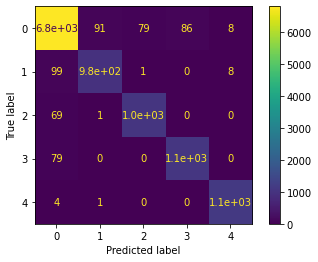

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test) 

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7065
           1       0.91      0.90      0.91      1087
           2       0.93      0.94      0.93      1120
           3       0.93      0.93      0.93      1164
           4       0.99      1.00      0.99      1125

    accuracy                           0.95     11561
   macro avg       0.94      0.95      0.94     11561
weighted avg       0.95      0.95      0.95     11561



### Perform 5 Class Classification using Random Forest 

In [ ]:
## Random Forest Clasifier

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier() # n_estimator = 100,150,200,250, criteria = 'gini','entropy', bootstrap = True
rf.fit(X_train, y_train)
print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of Random Forest classifier on training set: 1.00
Accuracy of Random Forest classifier on test set: 0.97


#### Save the model

In [ ]:
import joblib
joblib.dump(rf, "ML/gyrModel.joblib")

# with open('ML/gyrModel.pkl', 'wb') as f:
#     cPickle.dump(rf, f)

['ML/gyrModel.joblib']

#### Metrics for Random Forest Algorithm

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      7065
           1       0.97      0.90      0.94      1087
           2       0.97      0.94      0.95      1120
           3       0.96      0.96      0.96      1164
           4       0.99      0.99      0.99      1125

    accuracy                           0.97     11561
   macro avg       0.97      0.96      0.96     11561
weighted avg       0.97      0.97      0.97     11561



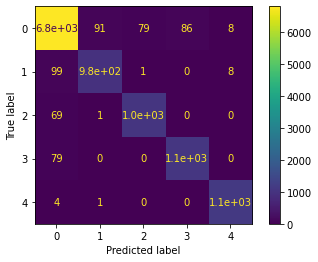

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test) 

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix= confusion_matrix(y_test, y_pred)


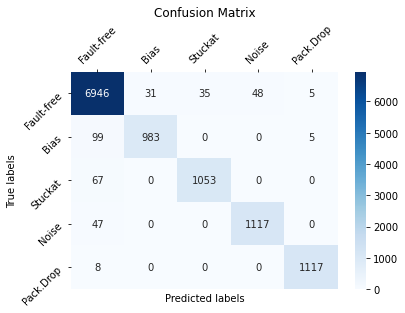

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax,cmap="Blues");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Fault-free', 'Bias','Stuckat','Noise','Pack.Drop'],rotation=45); 
ax.yaxis.set_ticklabels(['Fault-free', 'Bias','Stuckat','Noise','Pack.Drop'],rotation=45);
ax.xaxis.tick_top()


In [ ]:
# ## Support Vector Machine (SVM)

# from sklearn.svm import SVC
# svm = SVC()
# svm.fit(X_train, y_train.values.ravel())
# print('Accuracy of SVM classifier on training set: {:.2f}'
#      .format(svm.score(X_train, y_train)))
# print('Accuracy of SVM classifier on test set: {:.2f}'
#      .format(svm.score(X_test, y_test)))